# Pre-trained model

Starting from v0.5.0 detectree comes with a pre-trained model which can be used out-of-the-box to perform aerial imagery. Such a model has been trained using [Zurich's RGB orthophoto of summer 2014/15](https://www.geolion.zh.ch/geodatensatz/2831) resampled at a 0.5 m resolution - the model is actually the result of [the "cluster-I" notebook](https://github.com/martibosch/detectree-examples/blob/main/notebooks/cluster-I.ipynb). See the notebook or [the Hugging Face Hub](https://huggingface.co/martibosch/detectree) for more details about the training data and validation.

The pre-trained model is likely to work well for similar imagery, e.g., from regions with continental and oceanic climates at resolutions close to 0.5 m. It may work for other regions as well, but this is hard to know beforehand.

In [ ]:
import tempfile
from os import path
from urllib import request

import detectree as dtr
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio import plot

figwidth, figheight = plt.rcParams["figure.figsize"]

Let us first define the following functions to automatically obtain a side-by-side plot from a text query (to be geocoded) and WMS service:

In [ ]:
def query_to_tile(query, base_wms_url, format, radius, res, epsg, dst_filepath):
    side = 2 * radius / res  # side of the square in pixels
    bbox = gpd.tools.geocode(query).to_crs(epsg=epsg).buffer(radius).total_bounds
    tile_url = base_wms_url.format(
        format=format,
        epsg=epsg,
        bbox=",".join([str(coord) for coord in bbox]),
        width=side,
        height=side,
    )
    _ = request.urlretrieve(tile_url, dst_filepath)
    return dst_filepath


def side_by_side_plot(query, base_wms_url, format, radius, res, epsg, **clf_kwargs):
    with tempfile.TemporaryDirectory() as tmp_dir:
        tile_filepath = query_to_tile(
            query,
            base_wms_url,
            format,
            radius,
            res,
            epsg,
            path.join(tmp_dir, f"tile.{format}"),
        )
        c = dtr.Classifier(**clf_kwargs)
        y = c.predict_img(tile_filepath)
        fig, axes = plt.subplots(1, 2, figsize=(2 * figwidth, figheight))
        with rio.open(tile_filepath) as src:
            plot.show(src, ax=axes[0])
    axes[1].imshow(y)
    return fig

Let us define the following arguments that we will use for all the WMS services

In [ ]:
radius = 200  # in meters
res = 0.5  # the pre-trained model was trained with 0.5 m resolution imagery
side = 2 * radius / res  # side of the square in pixels

## Swissimage WMS

Given that the training data of the pre-trained model is from Zurich, let us first see how the model performs elsewhere in Switzerland:

/home/martibosch/mambaforge/envs/detectree/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/martibosch/mambaforge/envs/detectree/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


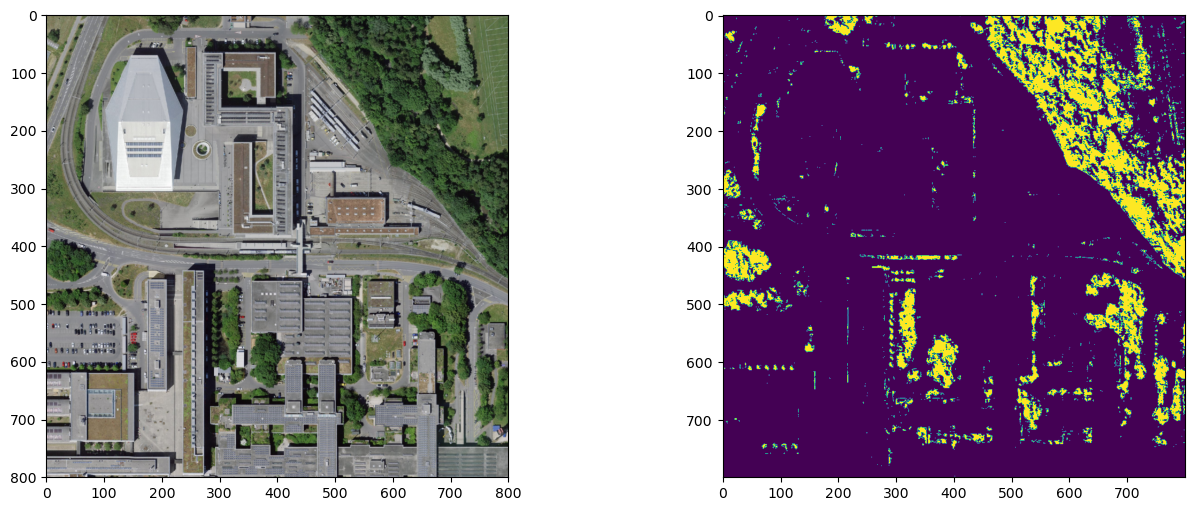

In [ ]:
ch_epsg = 2056
ch_base_wms_url = (
    "https://wms.geo.admin.ch/?SERVICE=WMS&REQUEST=GetMap&VERSION=1.3.0&"
    "FORMAT=image/{format}&LAYERS=ch.swisstopo.images-swissimage&CRS=EPSG:{epsg}&"
    "BBOX={bbox}&WIDTH={width}&HEIGHT={height}"
)
ch_args = [ch_base_wms_url, "png", radius, res, ch_epsg]
_ = side_by_side_plot("EPFL, Switzerland", *ch_args)

## ICGC Orthopoto

Let us get a tile of the Eixample in Barcelona from the [Orthophoto by the "Institut Cartogràfic i Geològic de Catalunya"](https://www.icgc.cat/en/Downloads/Aerial-and-satellite-images/Conventional-orthophoto):

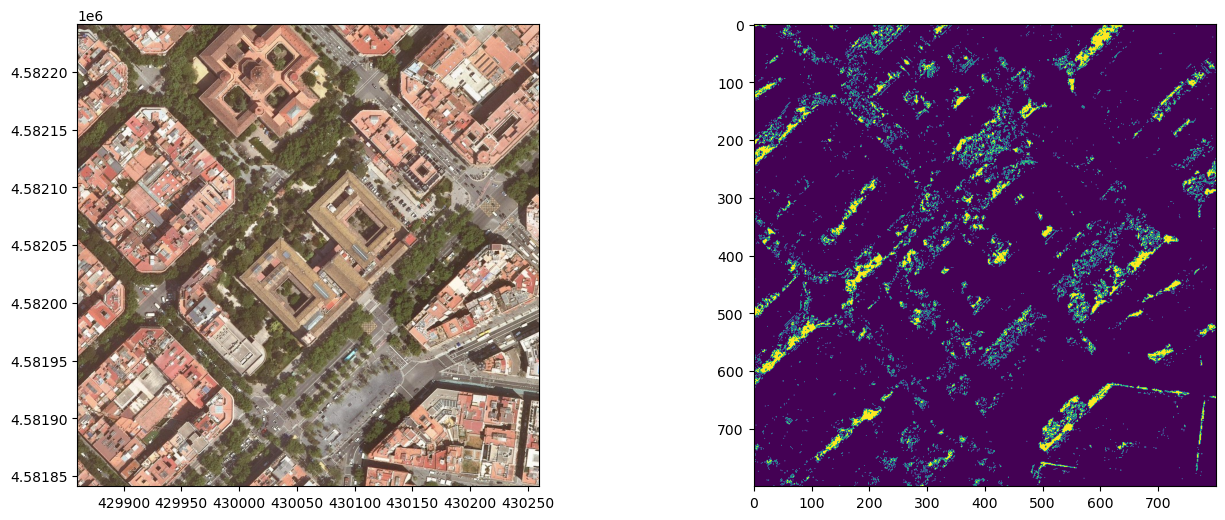

In [ ]:
cat_epsg = 25831
cat_base_wms_url = (
    "https://geoserveis.icgc.cat/icc_mapesmultibase/utm/wms/service?LAYERS=orto"
    "&FORMAT=image/{format}&SERVICE=WMS&VERSION=1.1.1&REQUEST=GetMap&STYLES="
    "&SRS=EPSG:{epsg}&BBOX={bbox}&WIDTH={width}&HEIGHT={height}"
)
cat_args = [cat_base_wms_url, "tiff", radius, res, cat_epsg]
_ = side_by_side_plot("Universitat de Barcelona", *cat_args)

It seems that many tree pixels are detected but not consistently enough. Instead, shaded parts are consistently classified as trees. This is likely because the trees from the training data in Zurich are darker, which may be linked to the tree characteristics, the time and conditions in which the imagery was acquired or the different tools used to obtain and process the imagery of the SWISSIMAGE and ICGC orthophoto. Under these circumstances, it is probably better to train another model as shown in the other notebooks of this repository.

Let us try another location for the ICGC:

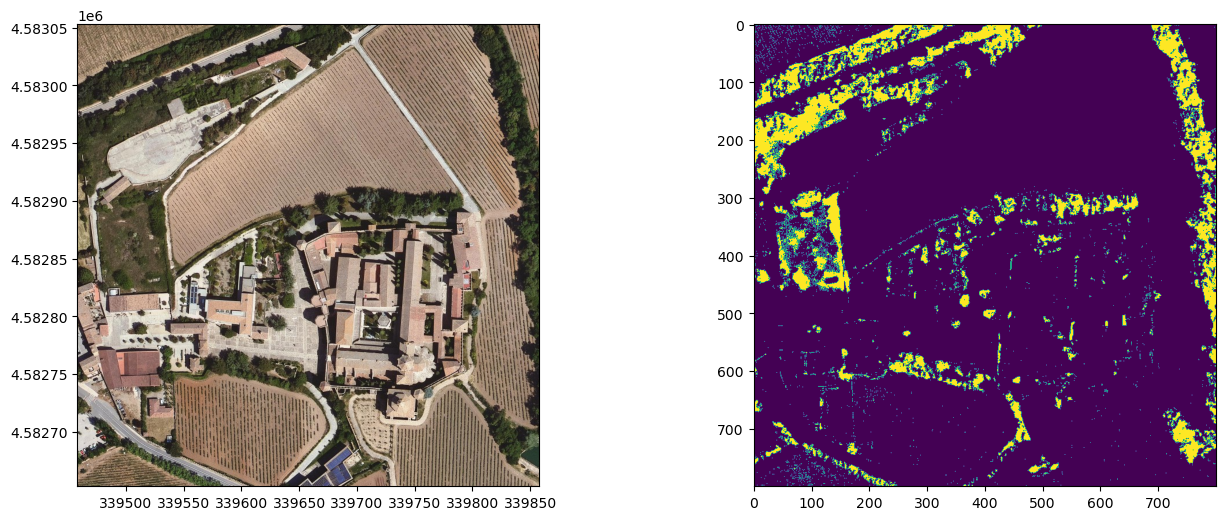

In [ ]:
_ = side_by_side_plot("Real Monestir de Santa Maria de Poblet, Catalunya", *cat_args)

Here tree pixels are consistently segmented, however there is some noise in low vegetation areas (mainly grass and vineyards). We can try changing the `refine_beta` argument of the classifier (see the [background notebook for more details on the refinement of the pixel-level classification](https://github.com/martibosch/detectree-examples/blob/main/notebooks/background.ipynb)):

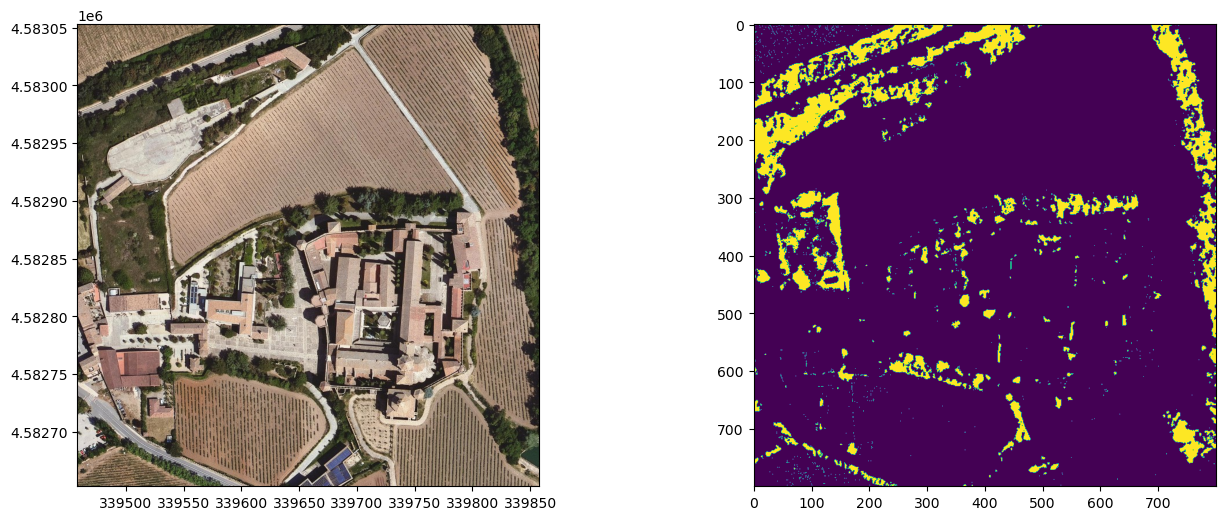

In [ ]:
_ = side_by_side_plot(
    "Real Monestir de Santa Maria de Poblet, Catalunya",
    *cat_args,
    refine_beta=2000,
)

## Ortofoto 2019 - AGEA

Let us get a tile of the city of Lecce from the [Puglia Ortofoto 2019 by the Italian agricultural payments agency (AGEA)](https://www.sit.puglia.it/portal/portale_cartografie_tecniche_tematiche/WMS):

http://webapps.sit.puglia.it/arcgis/services/BaseMaps/Ortofoto2019/ImageServer/WMSServer?layer=0&FORMAT=image/png&SERVICE=WMS&VERSION=1.1.1&REQUEST=GetMap&SRS=EPSG:32633&BBOX=769155.0767031224,4472016.668123412,769555.0767031224,4472416.668123412&WIDTH=800.0&HEIGHT=800.0


/home/martibosch/mambaforge/envs/detectree/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/martibosch/mambaforge/envs/detectree/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


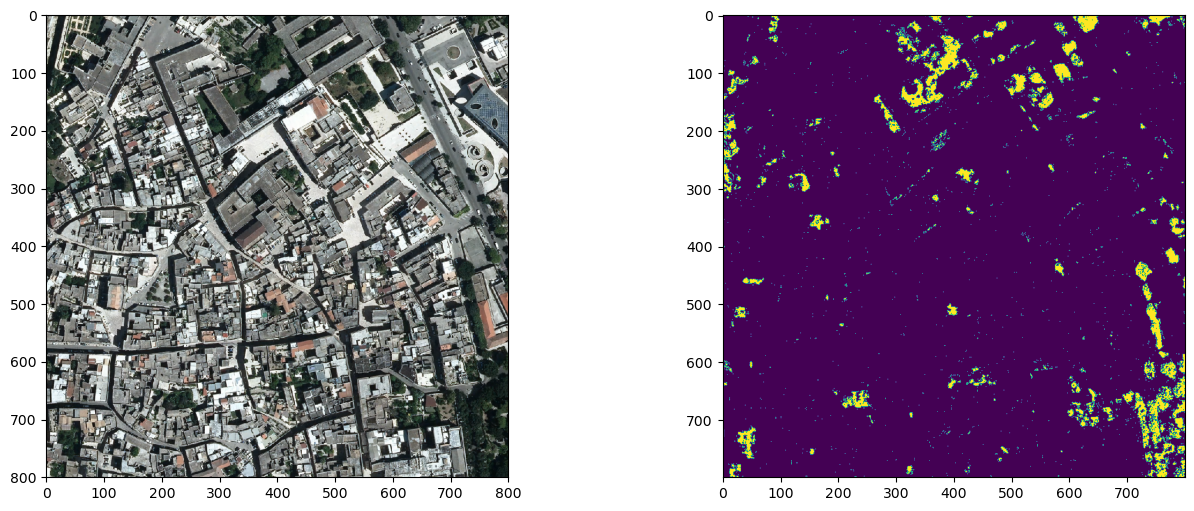

In [ ]:
pug_epsg = 32633
pug_base_wms_url = (
    "http://webapps.sit.puglia.it/arcgis/services/BaseMaps/Ortofoto2019/ImageServer/WMSServer?"
    "layer=0&FORMAT=image/{format}&SERVICE=WMS&VERSION=1.1.1&REQUEST=GetMap"
    "&SRS=EPSG:{epsg}&BBOX={bbox}&WIDTH={width}&HEIGHT={height}"
)
pug_args = [pug_base_wms_url, "png", radius, res, pug_epsg]
_ = side_by_side_plot("Lecce, Puglia", *pug_args)

The tree segmentation here seems to work quite well overall - likely because the trees appear darker.

Overall, it is hard to anticipate when the pre-trained model will work well. The best is to first try and see.